In [1]:
import jax
import jax.numpy as jnp
from jax.tree_util import tree_flatten, tree_unflatten, register_pytree_node
from jax import random, grad, jit, vmap, nn, value_and_grad
from jax.scipy.special import logsumexp
import random as r
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
# build the vocab mapping from char to int and vice versa
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
block_size = 3
# build the dataset

def create_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = jnp.array(X)
    Y = jnp.array(Y)
    return X, Y

# build a dataset of 80% train, 10% validation, and 10% test sets.
def split_dataset(words):
    r.seed(42)
    r.shuffle(words)
    n1 = int(0.8 * len(words))
    n2 = int(0.9 * len(words))

    Xtr, Ytr = create_dataset(words[:n1])
    Xval, Yval = create_dataset(words[n1:n2])
    Xte, Yte = create_dataset(words[n2:])

    return Xtr, Ytr, Xval, Yval, Xte, Yte

In [5]:
Xtr, Ytr, Xval, Yval, Xte, Yte = split_dataset(words)

In [6]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, df, g):
  ex = jnp.all(df == g).item()
  app = jnp.allclose(df, g)
  maxdiff = jnp.max(jnp.abs(df - g)).item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [7]:
key = random.PRNGKey(10)

In [8]:
n_embd = 10
n_hidden = 64

C = random.normal(key, (vocab_size, n_embd))
# Layer 1
W1 = random.normal(key, (n_embd * block_size, n_hidden)) * (5/3) / ((n_embd * block_size)**0.5)
b1 = random.normal(key, (n_hidden, )) * 0.1
# Layer 2
W2 = random.normal(key, (n_hidden, vocab_size)) * 0.1
b2 = random.normal(key, (vocab_size, )) * 0.1

# BatchNorm Parameters
bngain = jnp.ones((1, n_hidden)) * 0.1 + 1.0
bnbias = jnp.zeros((1, n_hidden)) * 0.1

parameters = [C, W1, b1, bngain, bnbias, W2, b2]

In [9]:
params, _ = tree_flatten(parameters)
sum(jnp.size(p) for p in params)

4137

In [10]:
batch_size = 32
n = batch_size # for convenience
# construct a minibatch
key, _ = random.split(key)
ix = random.randint(key, (batch_size, ), 0, Xtr.shape[0]) # create random batch indicies
Xb, Yb = Xtr[ix], Ytr[ix]

In [11]:
# Forward pass written out in small chunks to make backward pass possible
def calc_emb(C):
    return C[Xb]
emb = calc_emb(C)

def calc_emb_cat(emb):
    return jnp.reshape(emb, (-1, emb.shape[1] * emb.shape[2]))
emb_cat = calc_emb_cat(emb)

# Linear layer
def calc_hprebn(emb_cat, W1, b1):
    return emb_cat @ W1 + b1
hprebn = calc_hprebn(emb_cat, W1, b1)

# BatchNorm layer
def calc_bnmeani(hprebn):
    return 1/n*jnp.sum(hprebn, axis=0, keepdims=True)
bnmeani = calc_bnmeani(hprebn)

def calc_bndiff(hprebn, bnmeani):
    return hprebn - bnmeani
bndiff = calc_bndiff(hprebn, bnmeani)

def calc_bndiff2(bndiff):
    return bndiff**2
bndiff2 = calc_bndiff2(bndiff)

def calc_bnvar(bndiff2):
    return 1/(n-1) * jnp.sum(bndiff2, axis=0, keepdims=True)
bnvar = calc_bnvar(bndiff2)

def calc_bnvar_inv(bnvar):
    return (bnvar + 1e-5)**-0.5
bnvar_inv = calc_bnvar_inv(bnvar)

def calc_bnraw(bndiff, bnvar_inv):
    return bndiff * bnvar_inv
bnraw = calc_bnraw(bndiff, bnvar_inv)

def calc_hpreact(bngain, bnraw, bnbias):
    return bngain * bnraw + bnbias
hpreact = calc_hpreact(bngain, bnraw, bnbias)

# Non-linearity
def calc_h(hpreact):
    return jnp.tanh(hpreact)
h = calc_h(hpreact)

# Linear layer 2
def calc_logits(h, W2, b2):
    return h @ W2 + b2
logits = calc_logits(h, W2, b2) # output layer

# Cross entropy loss
def calc_logits_maxes(logits):
    return jnp.max(logits, axis=1, keepdims=True)
logits_maxes = calc_logits_maxes(logits)

def calc_norm_logits(logits, logits_maxes):
    return logits - logits_maxes
norm_logits = calc_norm_logits(logits, logits_maxes)

def calc_counts(norm_logits):
    return jnp.exp(norm_logits)
counts = calc_counts(norm_logits)

def calc_counts_sum(counts):
    return jnp.sum(counts, axis=1, keepdims=True)
counts_sum = calc_counts_sum(counts)

def calc_counts_sum_inv(counts_sum):
    return counts_sum**-1
counts_sum_inv = calc_counts_sum_inv(counts_sum)

def calc_probs(counts, counts_sum_inv):
    return counts * counts_sum_inv
probs = calc_probs(counts, counts_sum_inv)

def calc_logprobs(probs):
    return jnp.log(probs)
logprobs = calc_logprobs(probs)

def calc_loss(logprobs, Yb):
    def get_idx(prob, y):
        return -prob[y]
    vectorized_probs = vmap(get_idx)(logprobs, Yb)
    return vectorized_probs.mean()
loss = calc_loss(logprobs, Yb)
loss


Array(3.3010445, dtype=float32)

In [12]:
# Utility functions for differentiation
def d1(f, *args, argnums=0):
    return vmap(vmap(grad(f, argnums=argnums)))(*args)

def d2(f, *args, argnums=0):
    return jax.jacobian(f, argnums=argnums)(*args)


In [27]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)
# -----------------
def set_idx(logprob, y):
    return jnp.zeros_like(logprob).at[y].set(-1.0/n)
dlogprobs = vmap(set_idx)(logprobs, Yb)
cmp('logprobs', dlogprobs, d2(calc_loss, logprobs, Yb))

def calc_logprobs_loss(probs):
    return calc_loss(jnp.log(probs), Yb)
dprobs = (1.0 / probs) * dlogprobs
cmp('probs', dprobs, d2(calc_logprobs_loss, probs))


dlogprobs = vmap(set_idx)(logprobs, Yb)
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = jnp.sum(counts * dprobs, axis=1, keepdims=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = -counts_sum**-2 * dcounts_sum_inv
dcounts += jnp.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogit_maxes = jnp.sum(-dnorm_logits, axis=1, keepdims=True)
dlogits = dnorm_logits
dlogits += jax.nn.one_hot(jnp.argmax(logits, axis=1), num_classes=logits.shape[1])
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = jnp.sum(dlogits, axis=0)
dhpreact = (1.0 - h**2) * dh
dbngain = jnp.sum(bnraw * dhpreact, axis=0, keepdims=True)
dbnraw = bngain * hpreact
dbnbias = jnp.sum(hpreact, axis=0, keepdims=True)
dbndiff = bnvar_inv * dbnbias
dbnvar_inv = jnp.sum(bndiff * dbnbias, axis=0, keepdims=True)
dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*jnp.ones_like(bndiff2) * dbnvar
dbndiff += 2*bndiff * dbndiff2
dbnmeani = dbndiff
dhprebn = jnp.sum(-dbndiff, axis=0, keepdims=True)
dhprebn += 1.0/n * (jnp.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = dhprebn.T @ emb_cat
db1 = jnp.sum(dhprebn, axis=0)
demb = jnp.reshape(dembcat, emb.shape)

dC = jnp.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC = dC.at[ix].set(demb[k, j])
        
# cmp('counts_sum', dcounts_sum, counts_sum)
# cmp('counts', dcounts, counts)
# cmp('norm_logits', dnorm_logits, norm_logits)
# cmp('logit_maxes', dlogit_maxes, logit_maxes)
# cmp('logits', dlogits, logits)
# cmp('h', dh, h)
# cmp('W2', dW2, W2)
# cmp('b2', db2, b2)
# cmp('hpreact', dhpreact, hpreact)
# cmp('bngain', dbngain, bngain)
# cmp('bnbias', dbnbias, bnbias)
# cmp('bnraw', dbnraw, bnraw)
# cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
# cmp('bnvar', dbnvar, bnvar)
# cmp('bndiff2', dbndiff2, bndiff2)
# cmp('bndiff', dbndiff, bndiff)
# cmp('bnmeani', dbnmeani, bnmeani)
# cmp('hprebn', dhprebn, hprebn)
# cmp('embcat', dembcat, embcat)
# cmp('W1', dW1, W1)
# cmp('b1', db1, b1)
# cmp('emb', demb, emb)
# cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0


Array([[-1.2736817e-04, -1.0806198e-05,  5.5701275e-05, -6.1596787e-05,
         1.2251687e-04,  1.0473885e-04, -8.3467803e-06, -1.5144463e-05,
        -1.3653802e-04, -3.7624533e-05],
       [-3.4168766e-06,  6.2787156e-05,  1.1004545e-04, -2.8992587e-05,
         4.5495028e-05,  3.3202621e-06, -1.7150129e-05,  5.9222595e-05,
        -6.0228772e-06,  1.7638597e-07],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00],
       [-3.4168766e-06,  6.2787156e-05,  1.1004545e-04, -2.8992587e-05,
         4.5495028e-05,  3.3202621e-06, -1.7150129e-05,  5.9222595e-05,
        -6.0228772e-06,  1.7638597e-07],
       [-1.2736817e-04, -1.0806198e-05,  5.5701275e-05, -6.1596787e-05,
         1.2251687e-04,  1.0473885e-04, -8.3467803e-06, -1.5144463e-05,
        -1.3653802e-04, -3.7624533e-05],
       [-1.2736817e-04, -1.0806198e-05,  5.5701275e-05, -6.1596787e-05,
   

In [32]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# backward pass

# -----------------
# YOUR CODE HERE :)
dlogits = nn.softmax(logits, axis=1)
def sub_one_at_i(dlogits, y):
    return dlogits.at[y].set(dlogits[y] - 1)
dlogits = vmap(sub_one_at_i)(dlogits, Yb)
dlogits /= n
# -----------------

#cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

In [33]:
dlogits[0].sum()

Array(-1.7462298e-09, dtype=float32)

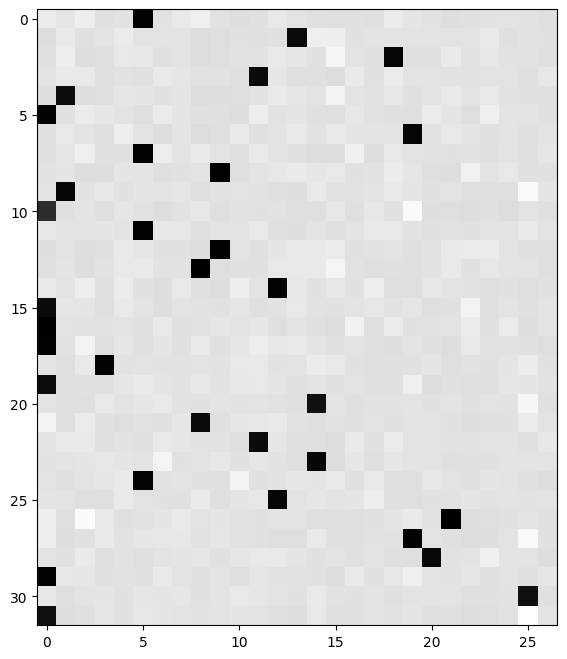

In [34]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits, cmap='gray')

In [35]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - jnp.sum(dhpreact, axis=0) - n/(n-1)*bnraw*jnp.sum(dhpreact*bnraw, axis=0))
# -----------------

In [36]:
dhprebn

Array([[ 0.04006269, -0.01033813, -0.01128102, ...,  0.00924037,
        -0.01258948,  0.01408514],
       [ 0.02640061,  0.0113443 , -0.08108643, ..., -0.0050826 ,
        -0.03298398, -0.0592458 ],
       [ 0.02429046, -0.02672904, -0.00632438, ...,  0.01607192,
         0.05619562,  0.06363728],
       ...,
       [-0.08752092,  0.01386603, -0.00091133, ...,  0.02416544,
         0.0635409 , -0.01679536],
       [-0.04196544,  0.02161659,  0.0666214 , ..., -0.01429155,
         0.01267565,  0.00161146],
       [-0.0438669 ,  0.02824033,  0.06811421, ..., -0.0248447 ,
         0.01716068, -0.00583593]], dtype=float32)

In [46]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass
key = random.PRNGKey(10)

n_embd = 10
n_hidden = 64

C = random.normal(key, (vocab_size, n_embd))
# Layer 1
W1 = random.normal(key, (n_embd * block_size, n_hidden)) * (5/3) / ((n_embd * block_size)**0.5)
b1 = random.normal(key, (n_hidden, )) * 0.1
# Layer 2
W2 = random.normal(key, (n_hidden, vocab_size)) * 0.1
b2 = random.normal(key, (vocab_size, )) * 0.1

# BatchNorm Parameters
bngain = jnp.ones((1, n_hidden)) * 0.1 + 1.0
bnbias = jnp.zeros((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

params, _ = tree_flatten(parameters)
print(sum(jnp.size(p) for p in params)) # number of parameters in total

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
#with torch.no_grad():

# kick off optimization
for i in range(max_steps):

    # minibatch construct
    key, _ = random.split(key)
    ix = random.randint(key, (batch_size, ), 0, Xtr.shape[0]) # create random batch indicies
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # Forward pass written out in small chunks to make backward pass possible
    emb = C[Xb]
    emb_cat = jnp.reshape(emb, (-1, emb.shape[1] * emb.shape[2]))
    hprebn = emb_cat @ W1 + b1
    bnmeani = 1/n*jnp.sum(hprebn, axis=0, keepdims=True)
    bndiff = hprebn - bnmeani
    bndiff2 = bndiff**2
    bnvar = 1/(n-1) * jnp.sum(bndiff2, axis=0, keepdims=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = bndiff * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    h = jnp.tanh(hpreact)
    logits = h @ W2 + b2
    logits_maxes = jnp.max(logits, axis=1, keepdims=True)
    norm_logits = logits - logits_maxes
    counts = jnp.exp(norm_logits)
    counts_sum = jnp.sum(counts, axis=1, keepdims=True)
    counts_sum_inv = counts_sum**-1
    probs = counts * counts_sum_inv
    logprobs = jnp.log(probs)

    def get_idx(prob, y):
        return -prob[y]
    vectorized_probs = vmap(get_idx)(logprobs, Yb)
    loss = vectorized_probs.mean()

    # manual backprop! #swole_doge_meme
    # -----------------
    # YOUR CODE HERE :)
    dlogits = nn.softmax(logits, axis=1)
    def sub_one_at_i(dlogits, y):
        return dlogits.at[y].set(dlogits[y] - 1)
    dlogits = vmap(sub_one_at_i)(dlogits, Yb)
    dlogits /= n
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = jnp.sum(dlogits, axis=0)
    dhpreact = (1.0 - h**2) * dh
    dbngain = jnp.sum(bnraw * dhpreact, axis=0, keepdims=True)
    dbnraw = bngain * hpreact
    dbnbias = jnp.sum(hpreact, axis=0, keepdims=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - jnp.sum(dhpreact, axis=0) - n/(n-1)*bnraw*jnp.sum(dhpreact*bnraw, axis=0))
    dembcat = dhprebn @ W1.T
    dW1 = emb_cat.T @ dhprebn
    db1 = jnp.sum(dhprebn, axis=0)
    demb = jnp.reshape(dembcat, emb.shape)

    dC = jnp.zeros_like(C)
    for k in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            ix = Xb[k, j]
            dC = dC.at[ix].set(demb[k, j])

    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    # for p, grad in zip(parameters, grads):
        # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
        # p = p -lr * grad # new way of swole doge TODO: enable
    parameters = [ p - lr * g for p, g in zip(parameters, grads) ]
    C, W1, b1, W2, b2, bngain, bnbias = parameters
    print(parameters)

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(jnp.log10(loss).item())

    if i >= 100: # TODO: delete early breaking when you're ready to train the full net
       break

4137
[Array([[ 1.3644153 ,  1.2825259 , -0.30163756,  2.4683213 , -2.8502717 ,
         0.2565324 ,  0.5625534 , -2.047897  ,  0.78425443,  0.330083  ],
       [ 0.48791054, -1.5596958 , -1.124009  , -0.7742652 , -0.5853394 ,
        -0.8113365 ,  0.867319  ,  1.0672581 , -1.1236871 ,  0.7312588 ],
       [-0.4076572 ,  0.4474688 , -0.03953756,  0.43151596,  2.3793542 ,
         1.3897084 , -2.2533367 ,  0.9831316 , -0.28425667, -0.2908234 ],
       [-0.69751257, -0.6811822 ,  1.7738794 , -0.3280694 ,  1.2811446 ,
         1.9261177 , -0.31635472,  0.20949422, -0.2902693 , -0.9565506 ],
       [-2.3365166 ,  1.0039792 ,  0.89819497, -1.4947366 , -0.97716194,
         0.49440897, -0.1079201 ,  0.02584517, -0.69558364,  0.01683336],
       [ 1.4425751 ,  0.26801297, -0.76546335, -1.3687907 , -0.31421408,
         0.3116932 ,  0.5283352 ,  0.8451245 ,  2.4852777 , -0.5931107 ],
       [-0.3339679 , -0.5802826 , -0.14225408,  0.60080314,  0.37448922,
         0.40825593, -0.7898745 , -0.28

In [ ]:
# calibrate the batch norm at the end of training

# pass the training set through
emb = C[Xtr]
embcat = emb.reshape(emb.shape[0], -1)
hpreact = embcat @ W1 + b1
# measure the mean/std over the entire training set
bnmean = jnp.mean(hpreact, axis=0, keepdim=True)
bnvar = jnp.var(hpreact, axis=0, keepdim=True, unbiased=True)

In [ ]:
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.reshape(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = jnp.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    logits_maxes = jnp.max(logits, axis=1, keepdims=True)
    norm_logits = logits - logits_maxes
    counts = jnp.exp(norm_logits)
    counts_sum = jnp.sum(counts, axis=1, keepdims=True)
    counts_sum_inv = counts_sum**-1
    probs = counts * counts_sum_inv
    logprobs = jnp.log(probs)
    def calc_loss(logprobs, Yb):
        def get_idx(prob, y):
            return -prob[y]
        vectorized_probs = vmap(get_idx)(logprobs, Yb)
        return vectorized_probs.mean()
    loss = calc_loss(logprobs, Yb)
    print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
import torch
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    # forward pass
    emb = C[torch.tensor([context])] # (1,block_size,d)      
    embcat = emb.reshape(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = jnp.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    # sample
    probs = nn.softmax(logits, dim=1)
    ix = torch.multinomial(torch.tensor(probs.tolist()), num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))